In [19]:
import numpy as np
# import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.image import load_img ,img_to_array

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

path = "data/Dataset_BUSI_with_GT"

In [2]:
dir_list = [i for i in os.listdir(path)]
# first item on list is .DS_store so remove that
dir_list.pop(0)

size_dict = {}
for i, value in enumerate(dir_list):
    size_dict[value] = len(os.listdir(os.path.join(path, value)))
size_dict

{'malignant': 422, 'benign': 891, 'normal': 266}

In [3]:
# Initialize data structures
# X_b -- benign image
# Xm_b -- masked version of bening image
# y_b -- class for bening images
# likewise, n -- normal and m -- malignant
img_size = 128
X_b , Xm_b , y_b = np.zeros((437, img_size, img_size, 1)), np.zeros((437, img_size, img_size, 1)), np.full(437, 0) 
X_n , Xm_n , y_n = np.zeros((133, img_size, img_size, 1)), np.zeros((133, img_size, img_size, 1)), np.full(133, 1) 
X_m , Xm_m , y_m = np.zeros((210, img_size, img_size, 1)), np.zeros((210, img_size, img_size, 1)), np.full(210, 2)

# Read in malignant data
for file in os.listdir(os.path.join(path, 'malignant')): 
    if 'DS_Store' in file: 
        break
    if 'mask' in file: 
        if file[-5] == '1': 
            num = int(file.strip('malignant (').strip(')_mask_1.png'))
        else: 
            num = int(file.strip('malignant (').strip(')_mask.png'))
        Xm_m[num - 1] += img_to_array(load_img(os.path.join(path, 'malignant', file), 
                                              color_mode = 'grayscale', target_size = (128, 128)))
    else: 
        num = int(file.strip('malignant (').strip(').png'))
        X_m[num - 1] = img_to_array(load_img(os.path.join(path, 'malignant', file), 
                                              color_mode = 'grayscale', target_size = (128, 128)))
        
# Read in normal data
for file in os.listdir(os.path.join(path, 'normal')): 
    if 'DS_Store' in file: 
        break
    if 'mask' in file: 
        if file[-5] == '1': 
            num = int(file.strip('normal (').strip(')_mask_1.png'))
        else: 
            num = int(file.strip('normal (').strip(')_mask.png'))
        Xm_n[num - 1] += img_to_array(load_img(os.path.join(path, 'normal', file), 
                                              color_mode = 'grayscale', target_size = (128, 128)))
    else: 
        num = int(file.strip('normal (').strip(').png'))
        X_n[num - 1] = img_to_array(load_img(os.path.join(path, 'normal', file), 
                                              color_mode = 'grayscale', target_size = (128, 128)))
        
# Read in benign data
for file in os.listdir(os.path.join(path, 'benign')): 
    if 'DS_Store' in file: 
        break
    if 'mask' in file: 
        if file[-5] in ['1', '2']: 
            num = int(file.strip('benign (').strip('.png')[:-2].strip(')_mask'))
        else: 
            num = int(file.strip('benign (').strip(')_mask.png'))
        Xm_b[num - 1] += img_to_array(load_img(os.path.join(path, 'benign', file), 
                                              color_mode = 'grayscale', target_size = (128, 128)))
    else: 
        num = int(file.strip('benign (').strip(').png'))
        X_b[num - 1] = img_to_array(load_img(os.path.join(path, 'benign', file), 
                                              color_mode = 'grayscale', target_size = (128, 128)))

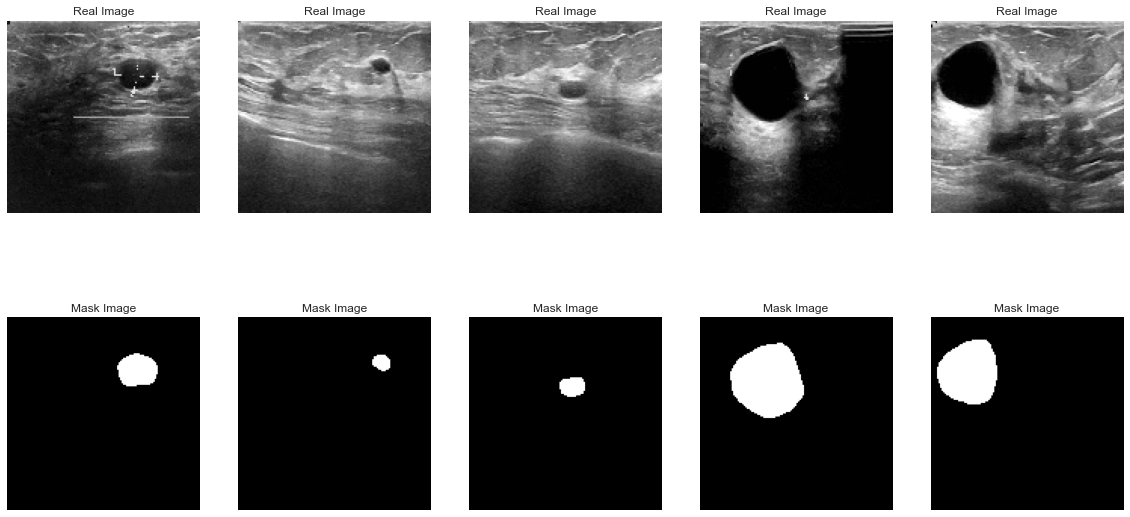

In [6]:
plt.figure(figsize = (20,10))

for i in range(5) :
    plt.subplot(2, 5, i+1)
    plt.imshow(X_b[i+5], 'gray')
    plt.title('Real Image')
    plt.axis('off')

for i in range(5) :
    plt.subplot(2, 5, i+6)
    plt.imshow(Xm_b[i+5], 'gray')
    plt.title('Mask Image')
    plt.axis('off')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

# Combine all data
X = np.concatenate((X_b, X_n, X_m), axis = 0)
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0, dtype = np.ndarray)

# Normalize the data
X /= 255.0
Xm /= 255.0

# Assign categorical vectors to y
y = to_categorical(y, num_classes = 3)
print(type(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 42)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, y, test_size = 0.3, shuffle = True, random_state = 42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

<class 'numpy.ndarray'>
(546, 128, 128, 1) (234, 128, 128, 1)
(546, 3) (234, 3)


In [8]:
def plot_model_parameters(history): 
    plt.figure(1, figsize = (20, 6))
    
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss', fontsize = 16)
    plt.ylabel('loss', fontsize = 16)
    plt.xlabel('epoch', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(['train', 'test'], loc='upper right', fontsize = 16)
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('accuracy', fontsize = 16)
    plt.xlabel('epoch', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(['train', 'test'], loc='upper left', fontsize = 16)
    
    plt.show()

In [20]:
# Model based on Kaggle notebook
model = Sequential()
    
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128,1)))           #(126,126,32)
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))    
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))   
model.add(MaxPooling2D((2,2)))

model.add(Flatten())                                                                                 

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.summary()

batch_size = 32
epochs = 25
opt = Adam(learning_rate = 1e-5)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = batch_size)

plot_model_parameters(history)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)              

KeyboardInterrupt: 

Observations: 
- Both train and test loss are decreasing 
- While training accuracy is increasing, test accuracy is relatively flat. This may indicate overfitting on the training set. 

So let's try adding in some dropout. 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)             

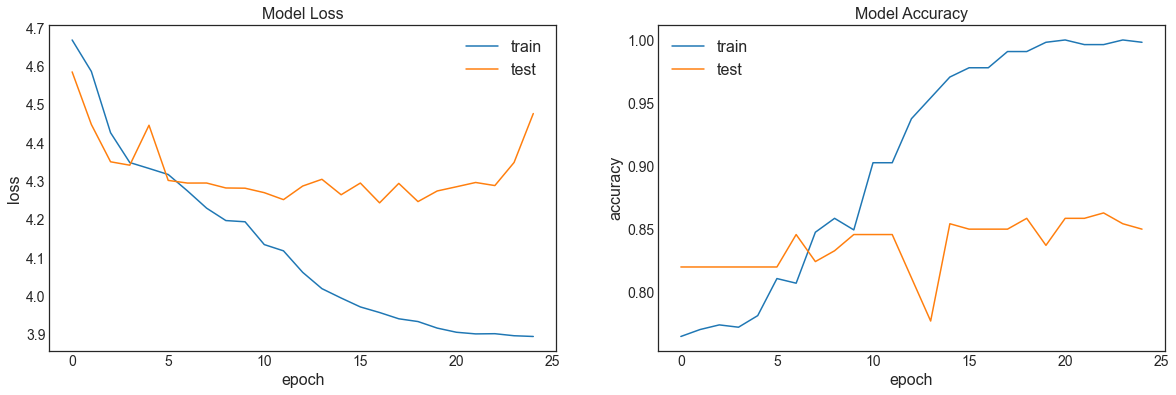

In [24]:
model_1 = Sequential()
    
model_1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128,1)))
model_1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l=0.01)))    
model_1.add(MaxPooling2D((2,2)))

model_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l=0.01)))   
model_1.add(MaxPooling2D((2,2)))

model_1.add(Flatten())                                                                              

model_1.add(Dense(128,activation='relu'))
model_1.add(Dense(64,activation='relu'))
model_1.add(Dense(32,activation='relu'))
model_1.add(Dense(3,activation='softmax'))

model_1.summary()

batch_size = 4
epochs = 25
opt = Adam(learning_rate = 1e-5)

model_1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_1 = model_1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = batch_size)

plot_model_parameters(history_1)

Tried: 
- model_1.add(Dropout(0.5)) between each Dense layer --> increase in loss, no change in accuracy
- model_1.add(Dropout(0.25)) between each Dense layer --> better but increase in loss again
- model_1.add(Dropout(0.25)) after MaxPooling --> better but still seeing overfitting 
- model_1.add(Dropout(0.25)) after each Conv2D --> loss is decreasing but accuracy stays the same; and maybe overfitting
- model_1.add(Dropout(0.5)) after each Conv2D --> flat training and test accuracies

Let's try playing around with the batch size next. Going back to the original model (no dropout). 
- Batch size of 4 --> Huge gains in training accuracy (100% at the end) but clearly overfitting **

So now with batch size of 4, let's add in some dropout. 
- model_1.add(Dropout(0.25)) after MaxPooling --> overfitting still present

Other regularization techniques: 
- L2 regularization on 2nd and 3rd Conv layer --> good training accuracy but no increase in test accuracy; more epochs? (accidentally left prev dropout layers in) **
- Double dropout (0.4 after MaxPooling, 0.2 between Dense layers) --> increase in loss, no learning
- L2 reg + Dropout(0.4) after MaxPooling --> no good
- L2 reg w/o dropout --> good but overfitting, prob better to keep dropout in **

** best ones

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_58 (Dense)             (None, 3)               

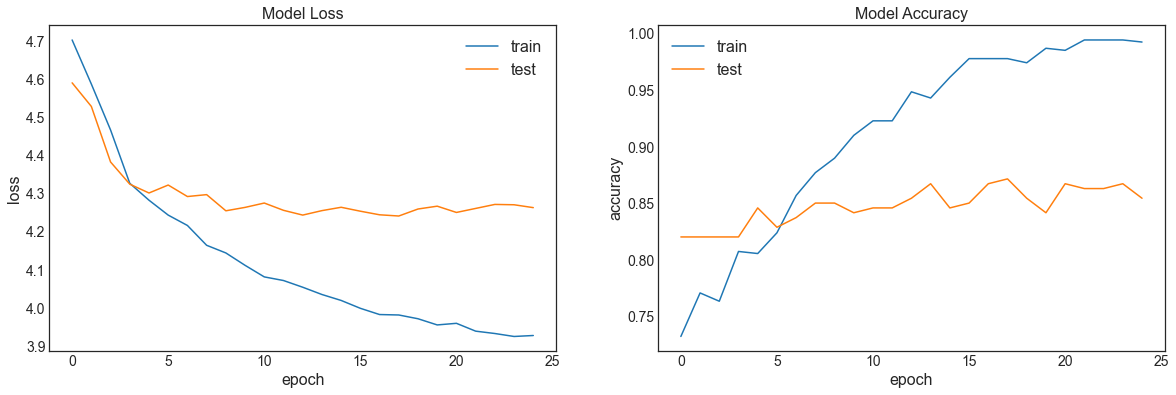

In [28]:
# Let's try simplifying our model a little. There are probably too many parameters for the small dataset that we have.

model_2 = Sequential()
    
model_2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128,1)))
model_2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l=0.01)))    
model_2.add(MaxPooling2D((2,2)))
model_1.add(Dropout(0.25))

model_2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l=0.01)))   
model_2.add(MaxPooling2D((2,2)))
model_1.add(Dropout(0.25))

model_2.add(Flatten())                                                                              

#model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(3, activation='softmax'))

model_2.summary()

batch_size = 4
epochs = 25
opt = Adam(learning_rate = 1e-5)

model_2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_2 = model_2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = batch_size)

plot_model_parameters(history_2)

Reducing the number of parameters: 
- Removed two dense layers (128 and 64) --> doesn't seem to help/hurt too much 
- Removed three dense layers (128, 64, 32) --> doesn't seem to help/hurt too much 

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 128)     

137/137 [==============================] - 3s 20ms/step - loss: 0.5412 - accuracy: 0.7703 - val_loss: 0.5904 - val_accuracy: 0.8205
Epoch 28/50
137/137 [==============================] - 3s 19ms/step - loss: 0.5631 - accuracy: 0.7822 - val_loss: 0.6047 - val_accuracy: 0.8205
Epoch 29/50
137/137 [==============================] - 3s 19ms/step - loss: 0.5597 - accuracy: 0.7382 - val_loss: 0.5905 - val_accuracy: 0.8205
Epoch 30/50
137/137 [==============================] - 3s 20ms/step - loss: 0.6507 - accuracy: 0.7134 - val_loss: 0.5757 - val_accuracy: 0.8205
Epoch 31/50
137/137 [==============================] - 3s 19ms/step - loss: 0.5686 - accuracy: 0.7817 - val_loss: 0.5835 - val_accuracy: 0.8205
Epoch 32/50
137/137 [==============================] - 3s 19ms/step - loss: 0.6171 - accuracy: 0.7647 - val_loss: 0.5824 - val_accuracy: 0.8205
Epoch 33/50
137/137 [==============================] - 3s 21ms/step - loss: 0.6983 - accuracy: 0.6952 - val_loss: 0.5547 - val_accuracy: 0.8205
Epoc

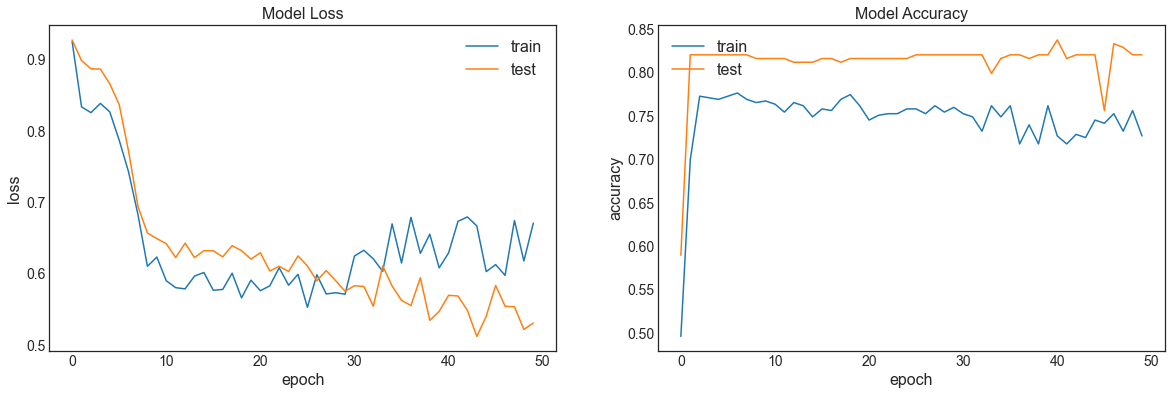

In [34]:
model_3 = Sequential()

model_3.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (128, 128, 1)))
model_3.add(MaxPooling2D(2, 2))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model_3.add(MaxPooling2D(2, 2))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model_3.add(MaxPooling2D(2, 2))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model_3.add(MaxPooling2D(2, 2))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(128, activation = 'relu'))

model_3.add(Dropout(0.5))
model_3.add(Dense(3, activation = 'softmax'))

model_3.summary()

batch_size = 4
epochs = 50
opt = Adam(learning_rate = 1e-5)

model_3.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_3 = model_3.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = batch_size)

plot_model_parameters(history_3)

Played around with the learning rate. 
- 1E-4: too large
- 1E-5: seems to be ok but model is not learning [flat loss and accuracy curves after few epochs]

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis = 1)
y_test_labels = np.argmax(y_test, axis = 1)

cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()